# Correlation and information flow plots

Results below show a negative correlation between LAI and MSLP for most grid points. This could be interpreted as:
1. Increase in LAI causes decrease in MSLP and decrease in LAI causes increase in MSLP (mechanism: additional transpiration and biogenic aerosols from vegetation facilitate water vapour condensation which leads to drop in air pressure, or higher sensible heat flux producing greater uplift to leave behind a low pressure region; in either case vegetation is implicated)
2. Decrease in MSLP causes increase in LAI and increase in MSLP causes decrease in LAI (mechanism: drop in air pressure due to other reasons draws in wind to push clouds and precipitation inland for vegetation growth)
3. A third confounding factor causes LAI and MSLP to move inversely (mechanism: higher solar intensity or land temperatures allow vegetation to grow but also for air to rise and leave behind a low pressure region)
4. These are just spurious correlations

To evaluate intepretation 2, we can make plots where grids use only the years where LAI was increasing, or was decreasing. In this case we know most of the LAI decrease was due to deforestation by humans rather than a change in atmospheric conditions. If the correlation holds for the years where LAI was decreasing, then this eliminates the second half of this interpretation (that a decrease in MSLP causes an increase in LAI). This is unless we argue that human activity during these periods have simultaneously caused a decrease in LAI (deforestation) and MSLP. But a mechanism for the latter still needs to be articulated, and be able to explain why these patterns are localised in space. Since the only proposed mechanism which seems to explain this localised pattern is the one in interpretation 1, this is the one we default to if interpretations 2, 3 and 4 all have evidence to the contrary.

If the correlational pattern is similar for both groups (whether LAI was increasing or decreasing), this would suggest (though not conclusively) that there is a common mechanism mediating LAI/MSLP regardless of whether LAI is increasing or decreasing. As the proposed mechanism here is that there are air pressure changes by external influences which end up determining vegetation growth via winds bringing in precipitating clouds, if we have eliminated the second half of interpretation 2 then this constitutes evidence against the mechanism itself and hence calls into question the validity of the first half of interpretation 2.

Interpretation 3 can be controlled to some extent by selection of study regions with relatively consistent temperature (such as countries near the equator). To evaluate interpretation 3, we can use a similar approach as described previously for interpretation 2 whereby we compare the correlational pattern in years of increasing and decreasing LAI. Again, most LAI decrease has been due to deforestation rather than a drop in temperature (temperatures near the equator do not fluctuate as much). And if the correlational pattern is similar across years of increasing and decreasing LAI, then this undermines the proposed mechanism.

To evaluate interpretation 4, we can compute p-values for the correlation at each grid cell and mask the correlation values accordingly. Given the large number of grid cells, care must be taken since a p-value of say 0.05 will still be expected to turn up a spurious correlation 1 in 20 times. So when evaluating the chance of spurious correlations on a region-wide level, analysis must consider the *fraction* of the total number of grid cells and make sure that this is a lot greater than the p-value chosen. To assist in this, a wider time range and higher temporal resolution can be used. Furthermore, cross-country comparisons can be made and if this correlation holds across regions of different climates then this would constitute some evidence against it being a spurious correlation.

Another method which evaluates all four interpretations simultaneously is the use of the information flow metric, which can actually indicate the direction of causality.

In summary, if we are able to establish that a similar correlation pattern holds across samples calculated upon years of increasing and decreasing LAI, and do so in countries near the equator where temperature is relatively consistent, then it is unlikely that interpretations 2 and 3 are valid. If we are furthermore able to demonstrate that the p-values for these correlations are significant on a region-wide level, and better yet holds across regions of different climates, then there is also reason to reject interpretation 4. In this case, interpretation 1 then becomes the most reasonable interpretation and the one we default to. This is unless someone can propose another counfounding mechanism which better explains these correlational patterns, or can successfully defend interpretation 2 by articulating another mechanism by which human activity could have increased MSLP and did so contemporaneously with deforestation (decrease in LAI).

In [1]:
# Import libraries

import glob
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import xskillscore as xs
import hvplot.xarray
from dask.distributed import Client

In [2]:
# Load datasets

msl_ds = xr.open_dataset("../data_raw/era5slvmonth-global/era5slvmonth-mslp", 
                           chunks = {'time': '500MB'},
                           engine = "cfgrib")
msl_ds = msl_ds.rename({"latitude": "lat",
               "longitude": "lon"}) # standardise names for xarray operations later

lai_files = glob.glob("../data_raw/c3slaiv3-global/*.nc")
lai_files.sort()
lai_ds = xr.open_mfdataset(lai_files, 
                           chunks = {'time': '500MB'},
                           engine = "netcdf4")

In [3]:
# Regrid and align data arrays

msl_da = msl_ds["msl"]
msl_da = (msl_da
          .assign_coords({"lat": msl_da.lat - 0.125,   # shift lat and lon coordinates by half of grid cell size since ERA5 data uses coordinates to define top left of grid cell
                          "lon": (((msl_da.lon) % 360) - 180) + 0.125})  # whereas xarray plotting assumes coordinates refer to middle of grid cell
          .coarsen(lat=2, lon=2, boundary="trim")      # ERA5 has 0.25 deg res while LAI has 1/30 deg res, lcm of these is 0.5 deg
          .mean()                                      # downsample the resolution to 0.5 deg by averaging over 4 grid cells (2 lat x 2 lon)
          .sel(lat=slice(79.75, -59.75))
         )
msl_da = msl_da.assign_coords({"time": msl_da.time.dt.strftime("%b-%Y")}) # standardise coordinates for xarray operations later

lat_coords = msl_da["lat"].data
lon_coords = msl_da["lon"].data

lai_da = lai_ds["LAI"]
lai_da = (lai_da
          .assign_coords({"lat": lai_da.lat - 1/60, # shift lat and lon coordinates by half of grid cell size since ERA5 data uses coordinates to define top left of grid cell
                          "lon": lai_da.lon + 1/60, # whereas xarray plotting assumes coordinates refer to middle of grid cell
                          "time": lai_da.time.dt.strftime("%b-%Y")}) # standardise coordinates for xarray operations later
          .coarsen(lat=15, lon=15, boundary="trim") # ERA5 has 0.25 deg res while LAI has 1/30 deg res, lcm of these is 0.5 deg
          .mean()                                   # downsample the resolution to 0.5 deg by averaging over 225 grid cells (15 lat x 15 lon)
         )
lai_da = lai_da.assign_coords({"lat": lat_coords, "lon": lon_coords}) # standardise coordinates for xarray operations later (this line is to avoid point errors)

msl_da, lai_da = xr.align(msl_da, lai_da, join = "inner") # perform inner join

/tmp/ipykernel_139704/2700566989.py:22: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  .mean()                                   # downsample the resolution to 0.5 deg by averaging over 225 grid cells (15 lat x 15 lon)


In [4]:
# Calculate correlation

# cor = xr.corr(msl_da, lai_da, dim = "time")

p = 0.1 # set p-value to deem significance

cor_p_r = xs.pearson_r(msl_da.chunk(dict(time=-1)), lai_da.chunk(dict(time=-1)), dim = 'time') # Pearson's correlation coefficient
cor_p_p = xs.pearson_r_p_value(msl_da.chunk(dict(time=-1)), lai_da.chunk(dict(time=-1)), dim = 'time') # p-value for Pearson's correlation
cor_p = cor_p_r.where(cor_p_p < p)

cor_s_r = xs.spearman_r(msl_da.chunk(dict(time=-1)), lai_da.chunk(dict(time=-1)), dim = 'time') # Spearman's correlation coefficient
cor_s_p = xs.spearman_r_p_value(msl_da.chunk(dict(time=-1)), lai_da.chunk(dict(time=-1)), dim = 'time') # p-value for Spearman's correlation
cor_s = cor_s_r.where(cor_s_p < p)

# Calculate difference approximations using Euler forward scheme (for input into information flow formula)

k = 1 # step size for euler forward scheme
deltat = 1 # time between each step in years

msl_da_trun = msl_da.isel(time=slice(0,-k))
msl_da_forw = msl_da.isel(time=slice(k, None)).assign_coords({"time": msl_da_trun.time})
msl_da_diff = (msl_da_forw - msl_da_trun) / (k * deltat) # difference approximation for time derivative of MSLP using Euler forward scheme

lai_da_trun = lai_da.isel(time=slice(0,-k))
lai_da_forw = lai_da.isel(time=slice(k, None)).assign_coords({"time": lai_da_trun.time})
lai_da_diff = (lai_da_forw - lai_da_trun) / (k * deltat) # difference approximation for time derivative of LAI using Euler forward scheme

# Calculate covariances for information flow
# index 1 is used for MSLP while index 2 is used for LAI

c11 = xr.cov(msl_da_trun, msl_da_trun, dim = "time")
c12 = xr.cov(msl_da_trun, lai_da_trun, dim = "time")
c21 = xr.cov(lai_da_trun, msl_da_trun, dim = "time")
c22 = xr.cov(lai_da_trun, lai_da_trun, dim = "time")
c1d1 = xr.cov(msl_da_trun, msl_da_diff, dim = "time")
c1d2 = xr.cov(msl_da_trun, lai_da_diff, dim = "time")
c2d1 = xr.cov(lai_da_trun, msl_da_diff, dim = "time")
c2d2 = xr.cov(lai_da_trun, lai_da_diff, dim = "time")

# Calculate information flow

t21 = (c11*c12*c2d1 - c12*c12*c1d1) / (c11*c11*c22 - c11*c12*c12) # from LAI to MSLP
t12 = (c22*c21*c1d2 - c21*c21*c2d2) / (c22*c22*c11 - c22*c21*c21) # from MSLP to LAI

In [5]:
# Open dask client

client = Client()
client

<Client: 'tcp://127.0.0.1:33213' processes=4 threads=12, memory=15.48 GiB>

## Global results, correlation plots (top 2) masked by p-values < 0.1

/home/anthony/anaconda3/envs/thesis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/anthony/anaconda3/envs/thesis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


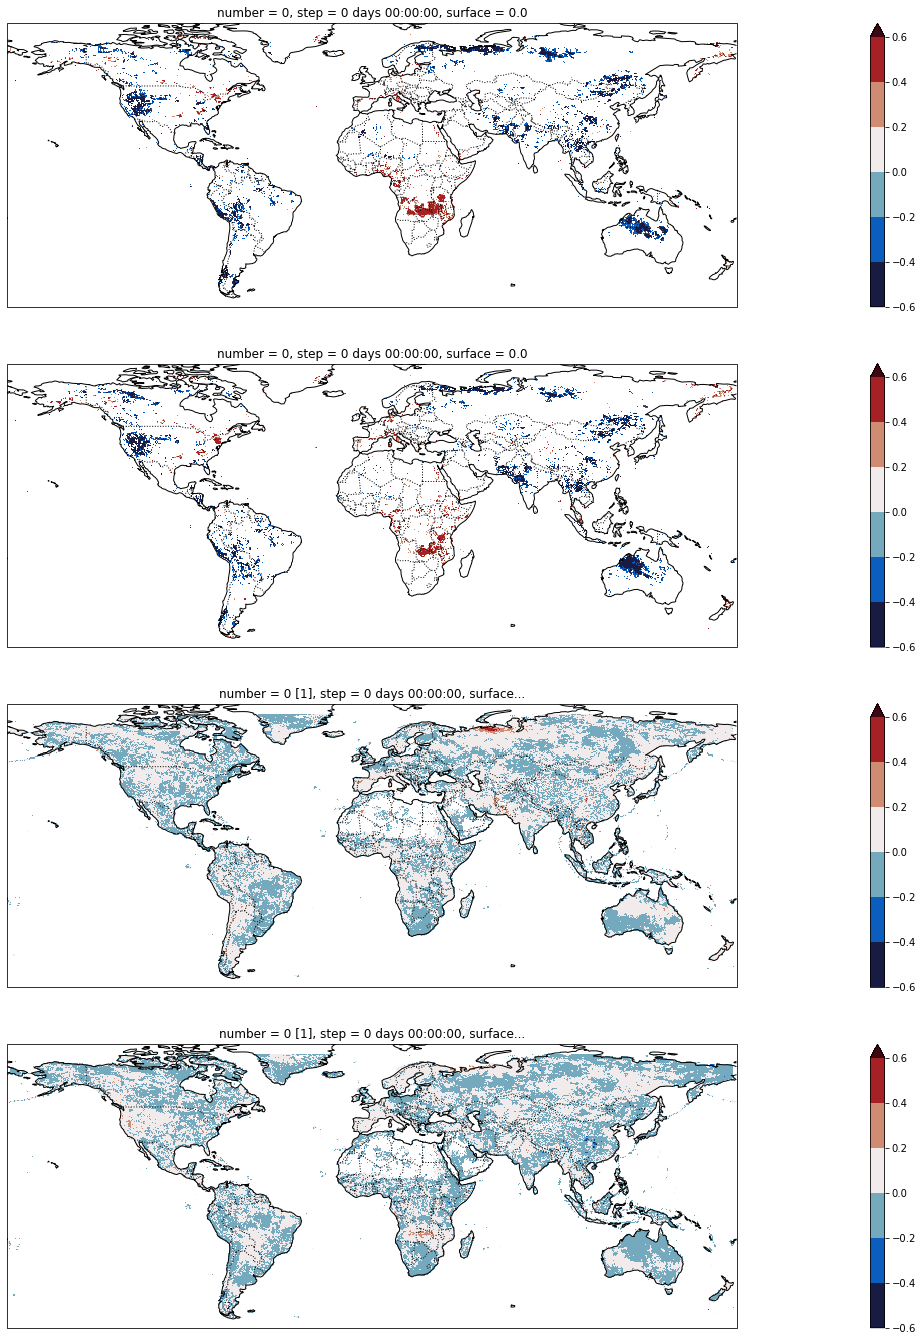

CPU times: user 10.4 s, sys: 1.51 s, total: 11.9 s
Wall time: 32.3 s


In [6]:
%%time

# Create plots:
# top left = statistically significant Pearson's coefficients
# top right = statistically significant Spearman's coefficients
# bottom left = information flow (nats per year) from LAI to MSLP
# bottom right = information flow (nats per year) from MSLP to LAI

fig = plt.figure(figsize=[48, 24])

ax1 = fig.add_subplot(4, 1, 1, projection=ccrs.PlateCarree())
cor_p.plot(ax = ax1, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
#ax1.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax1.add_feature(cfeature.LAND)
#ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
#ax1.add_feature(cfeature.LAKES, alpha=0.5)
#ax1.add_feature(cfeature.RIVERS)

ax2 = fig.add_subplot(4, 1, 2, projection=ccrs.PlateCarree())
cor_s.plot(ax = ax2, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
#ax2.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax2.add_feature(cfeature.LAND)
#ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
#ax2.add_feature(cfeature.LAKES, alpha=0.5)
#ax2.add_feature(cfeature.RIVERS)

ax3 = fig.add_subplot(4, 1, 3, projection=ccrs.PlateCarree())
t21.plot(ax = ax3, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
#ax3.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax3.add_feature(cfeature.LAND)
#ax3.add_feature(cfeature.OCEAN)
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')
#ax3.add_feature(cfeature.LAKES, alpha=0.5)
#ax3.add_feature(cfeature.RIVERS)

ax4 = fig.add_subplot(4, 1, 4, projection=ccrs.PlateCarree())
t12.plot(ax = ax4, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
#ax4.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax4.add_feature(cfeature.LAND)
#ax4.add_feature(cfeature.OCEAN)
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS, linestyle=':')
#ax4.add_feature(cfeature.LAKES, alpha=0.5)
#ax4.add_feature(cfeature.RIVERS)

plt.show()

## Global results, correlation plots (top 2) masked by p-values < 0.1, information flow plots (bottom 2) masked by Spearman p-values < 0.1

/home/anthony/anaconda3/envs/thesis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


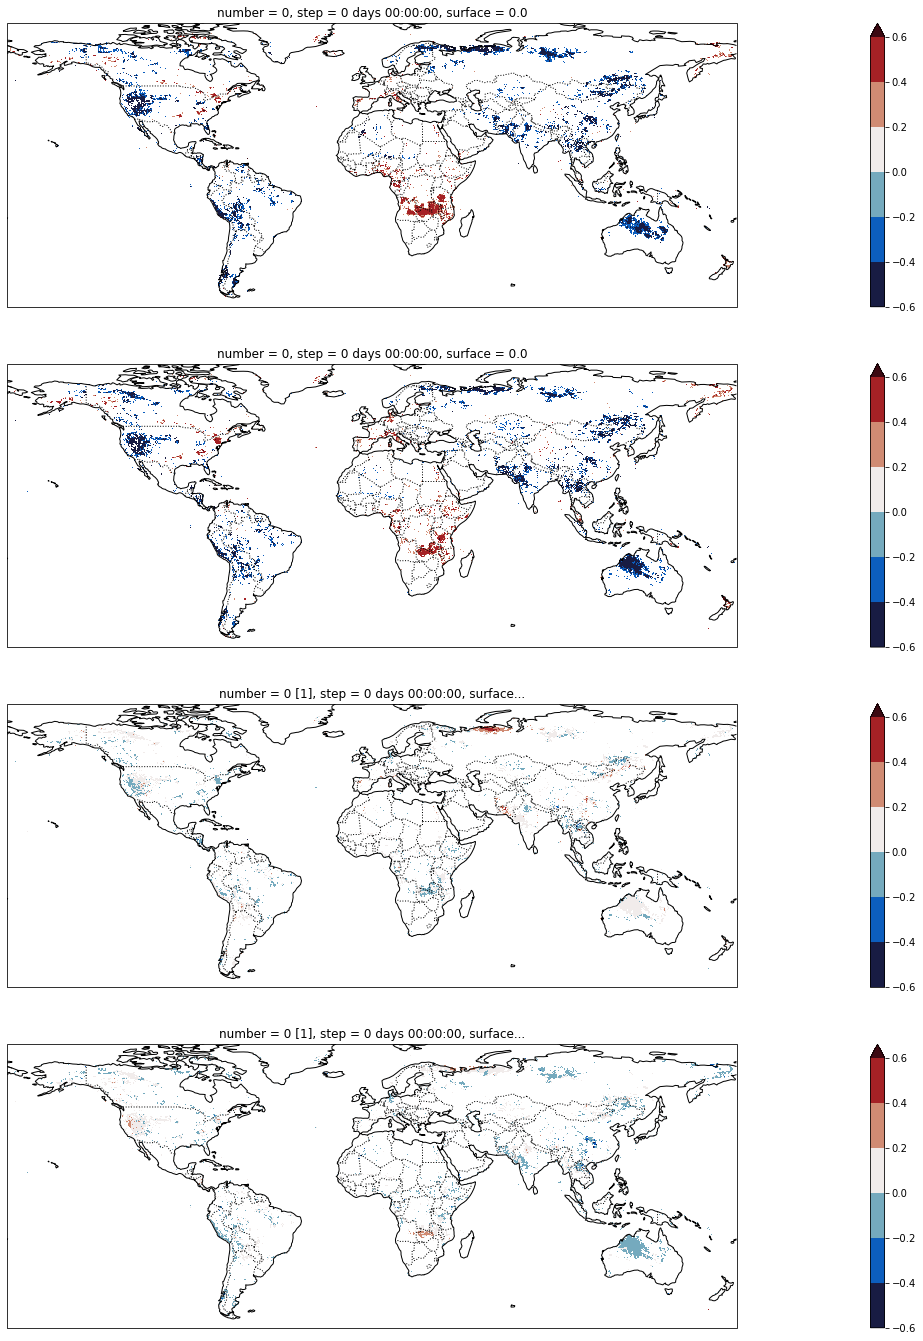

CPU times: user 12.8 s, sys: 1.65 s, total: 14.4 s
Wall time: 32.1 s


In [7]:
%%time

# Create plots:
# top left = statistically significant Pearson's coefficients
# top right = statistically significant Spearman's coefficients
# bottom left = information flow (nats per year) from LAI to MSLP
# bottom right = information flow (nats per year) from MSLP to LAI

fig = plt.figure(figsize=[48, 24])

ax1 = fig.add_subplot(4, 1, 1, projection=ccrs.PlateCarree())
cor_p.plot(ax = ax1, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
#ax1.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax1.add_feature(cfeature.LAND)
#ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
#ax1.add_feature(cfeature.LAKES, alpha=0.5)
#ax1.add_feature(cfeature.RIVERS)

ax2 = fig.add_subplot(4, 1, 2, projection=ccrs.PlateCarree())
cor_s.plot(ax = ax2, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
#ax2.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax2.add_feature(cfeature.LAND)
#ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
#ax2.add_feature(cfeature.LAKES, alpha=0.5)
#ax2.add_feature(cfeature.RIVERS)

ax3 = fig.add_subplot(4, 1, 3, projection=ccrs.PlateCarree())
t21.where(cor_s_p < p).plot(ax = ax3, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
#ax3.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax3.add_feature(cfeature.LAND)
#ax3.add_feature(cfeature.OCEAN)
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')
#ax3.add_feature(cfeature.LAKES, alpha=0.5)
#ax3.add_feature(cfeature.RIVERS)

ax4 = fig.add_subplot(4, 1, 4, projection=ccrs.PlateCarree())
t12.where(cor_s_p < p).plot(ax = ax4, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
#ax4.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax4.add_feature(cfeature.LAND)
#ax4.add_feature(cfeature.OCEAN)
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS, linestyle=':')
#ax4.add_feature(cfeature.LAKES, alpha=0.5)
#ax4.add_feature(cfeature.RIVERS)

plt.show()

## Central America results, correlation plots (top 2) masked by p-values < 0.1

/home/anthony/anaconda3/envs/thesis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/anthony/anaconda3/envs/thesis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


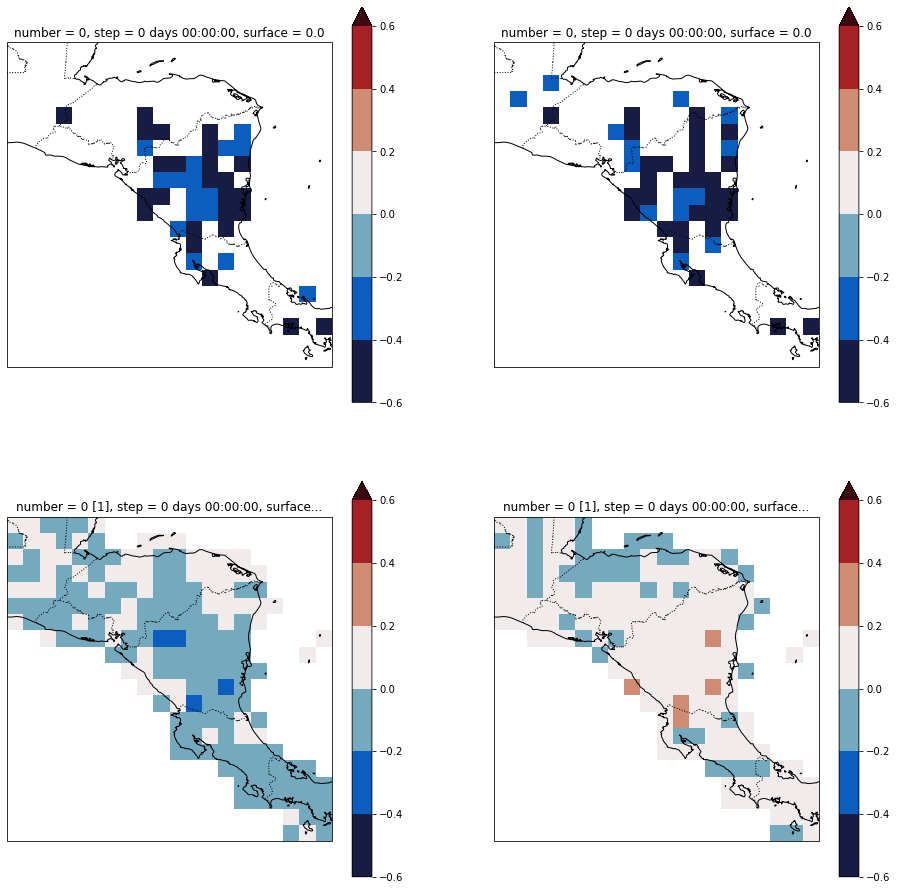

CPU times: user 12 s, sys: 1.49 s, total: 13.5 s
Wall time: 30.1 s


In [8]:
%%time

# Create plots:
# top left = statistically significant Pearson's coefficients
# top right = statistically significant Spearman's coefficients
# bottom left = information flow (nats per year) from LAI to MSLP
# bottom right = information flow (nats per year) from MSLP to LAI

fig = plt.figure(figsize=[16, 16])

ax1 = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
cor_p.plot(ax = ax1, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax1.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax1.add_feature(cfeature.LAND)
#ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
#ax1.add_feature(cfeature.LAKES, alpha=0.5)
#ax1.add_feature(cfeature.RIVERS)

ax2 = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())
cor_s.plot(ax = ax2, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax2.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax2.add_feature(cfeature.LAND)
#ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
#ax2.add_feature(cfeature.LAKES, alpha=0.5)
#ax2.add_feature(cfeature.RIVERS)

ax3 = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
t21.plot(ax = ax3, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax3.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax3.add_feature(cfeature.LAND)
#ax3.add_feature(cfeature.OCEAN)
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')
#ax3.add_feature(cfeature.LAKES, alpha=0.5)
#ax3.add_feature(cfeature.RIVERS)

ax4 = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
t12.plot(ax = ax4, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax4.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax4.add_feature(cfeature.LAND)
#ax4.add_feature(cfeature.OCEAN)
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS, linestyle=':')
#ax4.add_feature(cfeature.LAKES, alpha=0.5)
#ax4.add_feature(cfeature.RIVERS)

plt.show()

## Central America results, correlation plots (top 2) masked by p-values < 0.1, information flow plots (bottom 2) masked by Spearman p-values < 0.1

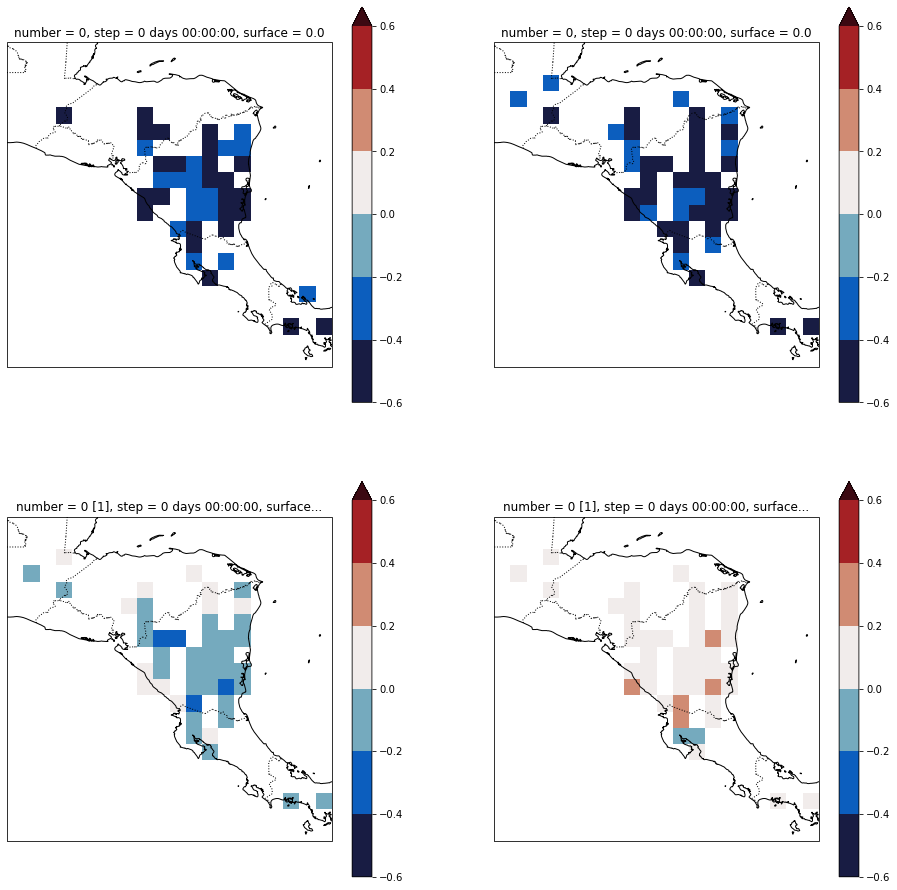

CPU times: user 11.8 s, sys: 1.5 s, total: 13.3 s
Wall time: 29.8 s


In [9]:
%%time

# Create plots:
# top left = statistically significant Pearson's coefficients
# top right = statistically significant Spearman's coefficients
# bottom left = information flow (nats per year) from LAI to MSLP
# bottom right = information flow (nats per year) from MSLP to LAI

fig = plt.figure(figsize=[16, 16])

ax1 = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
cor_p.plot(ax = ax1, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax1.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax1.add_feature(cfeature.LAND)
#ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
#ax1.add_feature(cfeature.LAKES, alpha=0.5)
#ax1.add_feature(cfeature.RIVERS)

ax2 = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())
cor_s.plot(ax = ax2, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax2.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax2.add_feature(cfeature.LAND)
#ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
#ax2.add_feature(cfeature.LAKES, alpha=0.5)
#ax2.add_feature(cfeature.RIVERS)

ax3 = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
t21.where(cor_s_p < p).plot(ax = ax3, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax3.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax3.add_feature(cfeature.LAND)
#ax3.add_feature(cfeature.OCEAN)
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')
#ax3.add_feature(cfeature.LAKES, alpha=0.5)
#ax3.add_feature(cfeature.RIVERS)

ax4 = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
t12.where(cor_s_p < p).plot(ax = ax4, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax4.set_extent([-91, -81, 7, 17], crs=ccrs.PlateCarree())
#ax4.add_feature(cfeature.LAND)
#ax4.add_feature(cfeature.OCEAN)
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS, linestyle=':')
#ax4.add_feature(cfeature.LAKES, alpha=0.5)
#ax4.add_feature(cfeature.RIVERS)

plt.show()

## Malay Archipelago results, correlation plots (top 2) masked by p-values < 0.1

/home/anthony/anaconda3/envs/thesis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/anthony/anaconda3/envs/thesis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


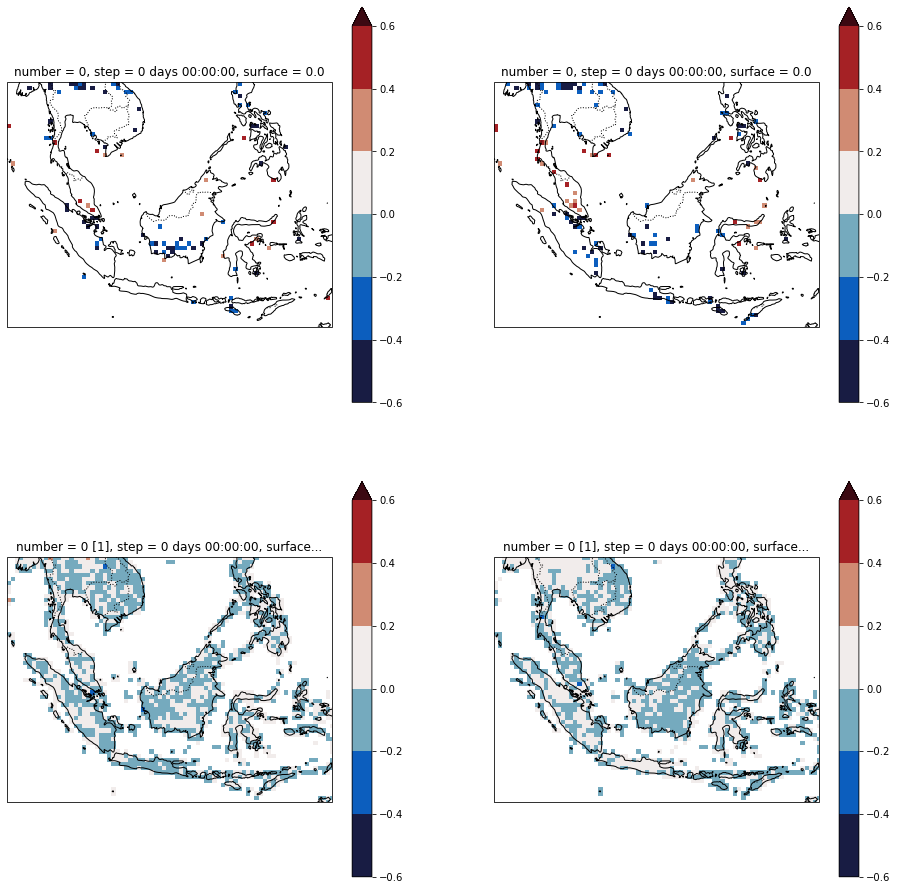

CPU times: user 12.2 s, sys: 1.66 s, total: 13.8 s
Wall time: 30.1 s


In [10]:
%%time

# Create plots:
# top left = statistically significant Pearson's coefficients
# top right = statistically significant Spearman's coefficients
# bottom left = information flow (nats per year) from LAI to MSLP
# bottom right = information flow (nats per year) from MSLP to LAI

fig = plt.figure(figsize=[16, 16])

ax1 = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
cor_p.plot(ax = ax1, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax1.set_extent([93.1, 131.7, -11.7, 17.4], crs=ccrs.PlateCarree())
#ax1.add_feature(cfeature.LAND)
#ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
#ax1.add_feature(cfeature.LAKES, alpha=0.5)
#ax1.add_feature(cfeature.RIVERS)

ax2 = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())
cor_s.plot(ax = ax2, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax2.set_extent([93.1, 131.7, -11.7, 17.4], crs=ccrs.PlateCarree())
#ax2.add_feature(cfeature.LAND)
#ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
#ax2.add_feature(cfeature.LAKES, alpha=0.5)
#ax2.add_feature(cfeature.RIVERS)

ax3 = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
t21.plot(ax = ax3, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax3.set_extent([93.1, 131.7, -11.7, 17.4], crs=ccrs.PlateCarree())
#ax3.add_feature(cfeature.LAND)
#ax3.add_feature(cfeature.OCEAN)
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')
#ax3.add_feature(cfeature.LAKES, alpha=0.5)
#ax3.add_feature(cfeature.RIVERS)

ax4 = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
t12.plot(ax = ax4, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax4.set_extent([93.1, 131.7, -11.7, 17.4], crs=ccrs.PlateCarree())
#ax4.add_feature(cfeature.LAND)
#ax4.add_feature(cfeature.OCEAN)
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS, linestyle=':')
#ax4.add_feature(cfeature.LAKES, alpha=0.5)
#ax4.add_feature(cfeature.RIVERS)

plt.show()

## Malay Archipelago results, correlation plots (top 2) masked by p-values < 0.1, information flow plots (bottom 2) masked by Spearman p-values < 0.1

/home/anthony/anaconda3/envs/thesis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


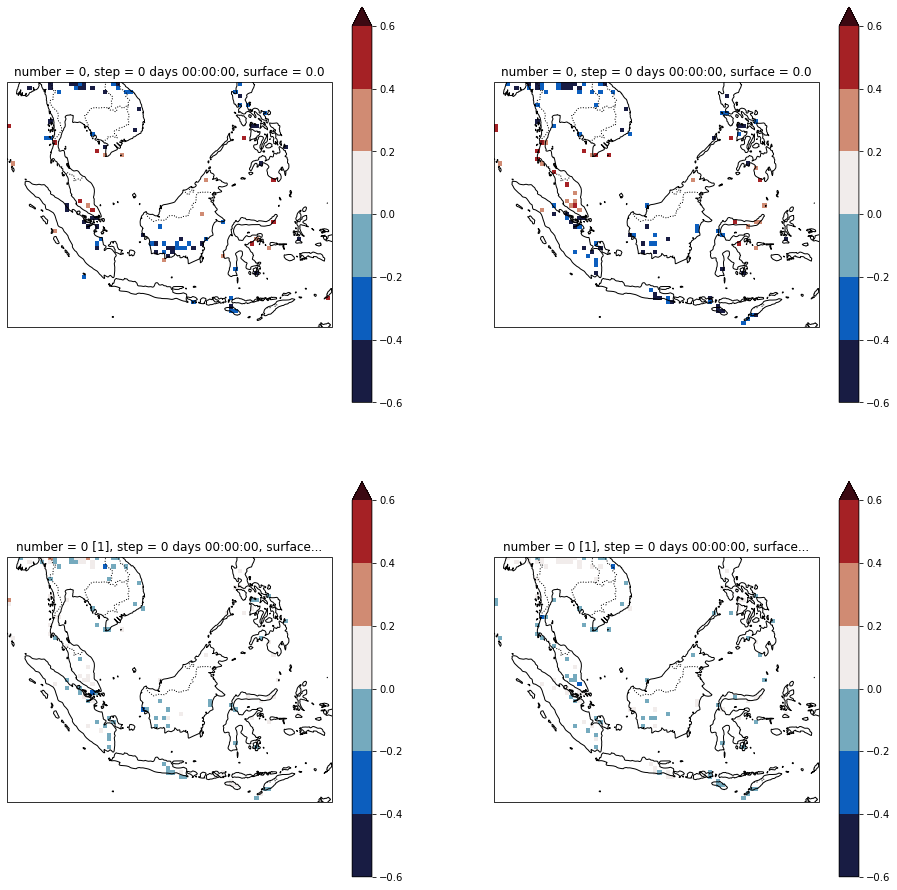

CPU times: user 12 s, sys: 1.61 s, total: 13.7 s
Wall time: 30.1 s


In [11]:
%%time

# Create plots:
# top left = statistically significant Pearson's coefficients
# top right = statistically significant Spearman's coefficients
# bottom left = information flow (nats per year) from LAI to MSLP
# bottom right = information flow (nats per year) from MSLP to LAI

fig = plt.figure(figsize=[16, 16])

ax1 = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
cor_p.plot(ax = ax1, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax1.set_extent([93.1, 131.7, -11.7, 17.4], crs=ccrs.PlateCarree())
#ax1.add_feature(cfeature.LAND)
#ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
#ax1.add_feature(cfeature.LAKES, alpha=0.5)
#ax1.add_feature(cfeature.RIVERS)

ax2 = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())
cor_s.plot(ax = ax2, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax2.set_extent([93.1, 131.7, -11.7, 17.4], crs=ccrs.PlateCarree())
#ax2.add_feature(cfeature.LAND)
#ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
#ax2.add_feature(cfeature.LAKES, alpha=0.5)
#ax2.add_feature(cfeature.RIVERS)

ax3 = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
t21.where(cor_s_p < p).plot(ax = ax3, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax3.set_extent([93.1, 131.7, -11.7, 17.4], crs=ccrs.PlateCarree())
#ax3.add_feature(cfeature.LAND)
#ax3.add_feature(cfeature.OCEAN)
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')
#ax3.add_feature(cfeature.LAKES, alpha=0.5)
#ax3.add_feature(cfeature.RIVERS)

ax4 = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
t12.where(cor_s_p < p).plot(ax = ax4, cmap=cmocean.cm.balance, extend = "max", levels = np.arange(-0.6, 0.61, 0.2), robust = True)
ax4.set_extent([93.1, 131.7, -11.7, 17.4], crs=ccrs.PlateCarree())
#ax4.add_feature(cfeature.LAND)
#ax4.add_feature(cfeature.OCEAN)
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS, linestyle=':')
#ax4.add_feature(cfeature.LAKES, alpha=0.5)
#ax4.add_feature(cfeature.RIVERS)

plt.show()

In [12]:
client.close()